<a href="https://colab.research.google.com/github/RachelRamirez/CIFAR-10/blob/main/Filter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [11]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import copy
import os
import PIL
import PIL.Image
from tensorflow import keras 
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
# import keras.utils -- dont do this!! it causes problems, 
from tensorflow.keras.utils import to_categorical  #do this instead!!
import random
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import time

tic = time.time()  # Start the timer
initial_run = 0


### Set Random Seeds

In [12]:
##  Random Seed
seed = 42
random.seed(seed)
tf.random.set_seed(seed)
## ------------------

Set Logic-Values


In [13]:
run_model = False  #When Im looking at augmentations, I don't want to keep refitting a model, I want to just get the database of images loaded

Make Image Datasets

One of my biggest learning curves was learning how to load  the dataset with tdfs.load() and then filter on images by label.  

The second biggest was using the created model to make predictions on the test set.   

Current but "skipped" problem is trying to view misclassifeid images of results.


Another area of problems is rerunning when you've already specified a batch on your dataset creates another "batch" split so it can cause problems to rerun a cell that says how to define a dataset.  Unbatch may be needed first.    

In [14]:
dataset, info = tfds.load('cifar10', as_supervised=True, with_info=True)
x_test =  dataset["test"]
dataset  = dataset["train"]
assert isinstance(x_test, tf.data.Dataset)
#x_test = [(example.numpy(), label.numpy()) for example, label in x_test]
# once broken into numpy arrays, my model still doesn't handle it, it seems to be expecting a tensor
# So i think i have to break it into two tensors?  test_x, test_y?
# x_test[0][0]
# x_test[0][1]
# x_test = pd.DataFrame(x_test, columns=['example', 'label'])
# x_test = tf.data.Dataset.from_generator(lambda: x_test, (tf.int64, tf.int16))
# x_list = list(x_test.as_numpy_iterator())  # Crashes Google Colab!
# print(x_list[:5])


# believe I got this from stack-overflow.  Need this code to define y_test, the labels of testset

def get_labels_from_tfdataset(tfdataset, batched=False):
    labels = list(map(lambda x: x[1], tfdataset)) # Get labels 
    if not batched:
        return tf.concat(labels, axis=0) # concat the list of batched labels
    return labels
y_test = get_labels_from_tfdataset(x_test)


dataset_airplanes   = dataset.filter(lambda img, label: label == 0)
dataset_automobiles = dataset.filter(lambda img, label: label == 1)
dataset_birds       = dataset.filter(lambda img, label: label == 2)
dataset_cats        = dataset.filter(lambda img, label: label == 3)
dataset_deers       = dataset.filter(lambda img, label: label == 4)
dataset_dogs        = dataset.filter(lambda img, label: label == 5)
dataset_frogs       = dataset.filter(lambda img, label: label == 6)
dataset_horses      = dataset.filter(lambda img, label: label == 7)
dataset_ships       = dataset.filter(lambda img, label: label == 8)
dataset_trucks      = dataset.filter(lambda img, label: label == 9)

##  Ways to count the number of images in the sets:
print("There are ways to count and verify the number per training set which i have hidden because they are costly")
print("Entire Training Dataset was originally cardinality:", tf.data.experimental.cardinality(dataset).numpy()) #   prints 50,000, correct
print("Entire Airplane Training Dataset was originally cardinality:", tf.data.experimental.cardinality(dataset_airplanes).numpy()) #   prints -2 this is a "feature" in tf when a set takes too long to count
# print(dataset_airplanes.reduce(np.int64(0), lambda x,_ : x + 1).numpy()) #prints 5000, correct

##  This is a way of asserting that all the images have the same label in a set
# for img, label in dataset_dogs:
#   assert label == 5
 

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incompleteHBRPOI/cifar10-train.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incompleteHBRPOI/cifar10-test.tfrecord


  0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.
There are ways to count and verify the number per training set which i have hidden because they are costly
Entire Training Dataset was originally cardinality: 50000
Entire Airplane Training Dataset was originally cardinality: -2


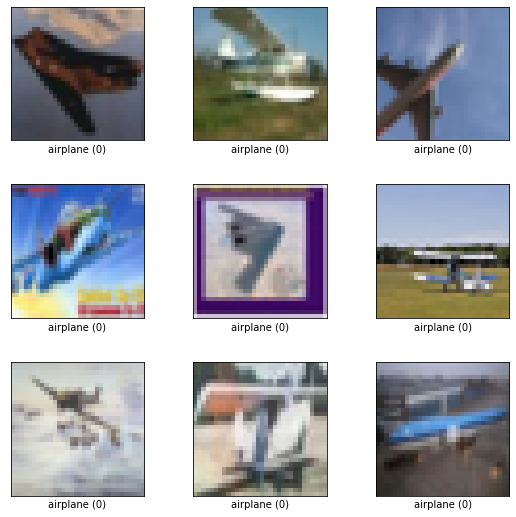

In [15]:
## Tfds.show_examples is a matplotlib funnction that only works on image ds's, and you have to pass it the "info" for some reason
fig = tfds.show_examples(dataset_airplanes, info)

How to display one picture of a dataset using `next(iter(dataset)`

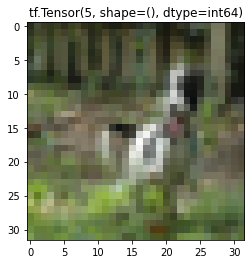

In [16]:
img, label = next(iter(dataset_dogs))

#print(img)
plt.title(str(label))
plt.imshow(img)

# Create validation set of 10,000 images

In [17]:
# I want 10 un replicated samples from dataset_airplanes + dataset_automobiles... dataset_trucks.

# There are 5000 images of each Class 
# I want 10 equal sets A, B, C, D, ... J plus a validation set
# I want 10,000 total images in the validation set with 1000 of each class
# and I want 10 sets of training images  4000 total images, so 400 images in each class

N = 1000
dataset_airplanes_val   = dataset_airplanes.take(N)
dataset_automobiles_val  = dataset_automobiles.take(N)
dataset_birds_val       = dataset_birds.take(N)  
dataset_cats_val        = dataset_cats.take(N)
dataset_deers_val       = dataset_deers.take(N)
dataset_dogs_val        = dataset_dogs.take(N)
dataset_frogs_val       = dataset_frogs.take(N)
dataset_horses_val      = dataset_horses.take(N)
dataset_ships_val       = dataset_ships.take(N)
dataset_trucks_val      = dataset_trucks.take(N)


# Make sure to skip the next 1000 images in each data set before making training set
dataset_airplanes   = dataset_airplanes.skip(N)
dataset_automobiles  = dataset_automobiles.skip(N)
dataset_birds      = dataset_birds.skip(N)  
dataset_cats        = dataset_cats.skip(N)
dataset_deers       = dataset_deers.skip(N)
dataset_dogs        = dataset_dogs.skip(N)
dataset_frogs       = dataset_frogs.skip(N)
dataset_horses      = dataset_horses.skip(N)
dataset_ships       = dataset_ships.skip(N)
dataset_trucks      = dataset_trucks.skip(N)

# # Check that remaining dataset does not have validation data
# fig = tfds.show_examples(dataset_ships, info)
# fig = tfds.show_examples(dataset_ships_val, info)
# # I checked and they dont.


# NOW, How do I combine my val sets?

# Hint1 its not this... 
# val = dataset_airplanes_val + dataset_automobile_val + dataset_birds_val

# #  Hint2 its also not this implementation of zip because the info file doesn't match it
# val = tf.data.Dataset.zip((dataset_airplanes_val,
#                     dataset_automobile_val,
#                     dataset_birds_val,
#                     dataset_cats_val,
#                     dataset_deers_val,
#                     dataset_dogs_val,
#                     dataset_frogs_val,
#                     dataset_horses_val,
#                     dataset_ships_val,
#                     dataset_trucks_val ))
 
# fig = tfds.show_examples(val, info)   # Returns a warning that the info file is not compatible


# is it concatenate? YESSSSSSSSSSSSSSSSSSSSSS
val = dataset_airplanes_val.concatenate(dataset_automobiles_val)
# This is how I checked that it worked
# fig = tfds.show_examples(val.skip(999), info)    # shows 1 airplane and then 8 automobiles

val = val.concatenate(dataset_birds_val)
val = val.concatenate(dataset_cats_val)
val = val.concatenate(dataset_deers_val)
val = val.concatenate(dataset_dogs_val)
val = val.concatenate(dataset_frogs_val)
val = val.concatenate(dataset_horses_val)
val = val.concatenate(dataset_ships_val)
val = val.concatenate(dataset_trucks_val)
  
# print(val.reduce(np.int32(0), lambda x,_ : x + 1))  # this shows 10000! Thank goodness! :-)



# Create 9 small groups of training_sets

 I "shard" the remaining training set into 16 groups and save 9 of them.

#### Airplanes (airplanes_A, ... airplanes_P)

In [18]:
# https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shard

# Check that each of the remaining 10 datasets has only 4000 images 
# print(dataset_airplanes.reduce(np.int32(0), lambda x,_ : x + 1))  # 4000 check!

# Shard each of the remaining 10 datasets into 16 smaller groups
airplanes_A = dataset_airplanes.shard(num_shards=16, index = 0)
airplanes_B = dataset_airplanes.shard(num_shards=16, index = 1)
airplanes_C = dataset_airplanes.shard(num_shards=16, index = 2)
airplanes_D = dataset_airplanes.shard(num_shards=16, index = 3)
airplanes_E = dataset_airplanes.shard(num_shards=16, index = 4)
airplanes_F = dataset_airplanes.shard(num_shards=16, index = 5)
airplanes_G = dataset_airplanes.shard(num_shards=16, index = 6)
airplanes_H = dataset_airplanes.shard(num_shards=16, index = 7)
airplanes_I = dataset_airplanes.shard(num_shards=16, index = 8)
airplanes_J = dataset_airplanes.shard(num_shards=16, index = 9)
airplanes_K = dataset_airplanes.shard(num_shards=16, index = 10)
airplanes_L = dataset_airplanes.shard(num_shards=16, index = 11)
airplanes_M = dataset_airplanes.shard(num_shards=16, index = 12)
airplanes_N = dataset_airplanes.shard(num_shards=16, index = 13)
airplanes_O = dataset_airplanes.shard(num_shards=16, index = 14)
airplanes_P = dataset_airplanes.shard(num_shards=16, index = 15)

#check that a random airplane dataset only has 250 images
# print(airplanes_M.reduce(np.int32(0), lambda x,_ : x + 1))  # 250 check!


#### Automobiles

In [19]:
# dataset_automobile

# Check that each of the remaining 10 datasets has only 4000 images 
# print(dataset_automobile.reduce(np.int32(0), lambda x,_ : x + 1))  # 4000 check!

# Shard each of the remaining 10 datasets into 16 smaller groups
automobiles_A = dataset_automobiles.shard(num_shards=16, index = 0)
automobiles_B = dataset_automobiles.shard(num_shards=16, index = 1)
automobiles_C = dataset_automobiles.shard(num_shards=16, index = 2)
automobiles_D = dataset_automobiles.shard(num_shards=16, index = 3)
automobiles_E = dataset_automobiles.shard(num_shards=16, index = 4)
automobiles_F = dataset_automobiles.shard(num_shards=16, index = 5)
automobiles_G = dataset_automobiles.shard(num_shards=16, index = 6)
automobiles_H = dataset_automobiles.shard(num_shards=16, index = 7)
automobiles_I = dataset_automobiles.shard(num_shards=16, index = 8)
automobiles_J = dataset_automobiles.shard(num_shards=16, index = 9)
automobiles_K = dataset_automobiles.shard(num_shards=16, index = 10)
automobiles_L = dataset_automobiles.shard(num_shards=16, index = 11)
automobiles_M = dataset_automobiles.shard(num_shards=16, index = 12)
automobiles_N = dataset_automobiles.shard(num_shards=16, index = 13)
automobiles_O = dataset_automobiles.shard(num_shards=16, index = 14)
automobiles_P = dataset_automobiles.shard(num_shards=16, index = 15)


#check that a random airplane dataset only has 250 images
# print(airplanes_H.reduce(np.int32(0), lambda x,_ : x + 1))  # 250 check!

#### Birds

In [20]:
# dataset_birds

# Shard each of the remaining 10 datasets into 16 smaller groups
birds_A = dataset_birds.shard(num_shards=16, index = 0)
birds_B = dataset_birds.shard(num_shards=16, index = 1)
birds_C = dataset_birds.shard(num_shards=16, index = 2)
birds_D = dataset_birds.shard(num_shards=16, index = 3)
birds_E = dataset_birds.shard(num_shards=16, index = 4)
birds_F = dataset_birds.shard(num_shards=16, index = 5)
birds_G = dataset_birds.shard(num_shards=16, index = 6)
birds_H = dataset_birds.shard(num_shards=16, index = 7)
birds_I = dataset_birds.shard(num_shards=16, index = 8)
birds_J = dataset_birds.shard(num_shards=16, index = 9)
birds_K = dataset_birds.shard(num_shards=16, index = 10)
birds_L = dataset_birds.shard(num_shards=16, index = 11)
birds_M = dataset_birds.shard(num_shards=16, index = 12)
birds_N = dataset_birds.shard(num_shards=16, index = 13)
birds_O = dataset_birds.shard(num_shards=16, index = 14)
birds_P = dataset_birds.shard(num_shards=16, index = 15)

#check that a random airplane dataset only has 250 images
# print(airplanes_H.reduce(np.int32(0), lambda x,_ : x + 1))  # 250 check!

#### Cats

In [21]:
# dataset_cats

# Shard each of the remaining 10 datasets into 16 smaller groups
cats_A = dataset_cats.shard(num_shards=16, index = 0)
cats_B = dataset_cats.shard(num_shards=16, index = 1)
cats_C = dataset_cats.shard(num_shards=16, index = 2)
cats_D = dataset_cats.shard(num_shards=16, index = 3)
cats_E = dataset_cats.shard(num_shards=16, index = 4)
cats_F = dataset_cats.shard(num_shards=16, index = 5)
cats_G = dataset_cats.shard(num_shards=16, index = 6)
cats_H = dataset_cats.shard(num_shards=16, index = 7)
cats_I = dataset_cats.shard(num_shards=16, index = 8)
cats_J = dataset_cats.shard(num_shards=16, index = 9)
cats_K = dataset_cats.shard(num_shards=16, index = 10)
cats_L = dataset_cats.shard(num_shards=16, index = 11)
cats_M = dataset_cats.shard(num_shards=16, index = 12)
cats_N = dataset_cats.shard(num_shards=16, index = 13)
cats_O = dataset_cats.shard(num_shards=16, index = 14)
cats_P = dataset_cats.shard(num_shards=16, index = 15)
#check that a random airplane dataset only has 250 images
# print(cats_P.reduce(np.int32(0), lambda x,_ : x + 1))  # 250 check!

#### Deer(s)

In [22]:
# dataset_deers
# Shard each of the remaining 10 datasets into 16 smaller groups
deers_A = dataset_deers.shard(num_shards=16, index = 0)
deers_B = dataset_deers.shard(num_shards=16, index = 1)
deers_C = dataset_deers.shard(num_shards=16, index = 2)
deers_D = dataset_deers.shard(num_shards=16, index = 3)
deers_E = dataset_deers.shard(num_shards=16, index = 4)
deers_F = dataset_deers.shard(num_shards=16, index = 5)
deers_G = dataset_deers.shard(num_shards=16, index = 6)
deers_H = dataset_deers.shard(num_shards=16, index = 7)
deers_I = dataset_deers.shard(num_shards=16, index = 8)
deers_J = dataset_deers.shard(num_shards=16, index = 9)
deers_K = dataset_deers.shard(num_shards=16, index = 10)
deers_L = dataset_deers.shard(num_shards=16, index = 11)
deers_M = dataset_deers.shard(num_shards=16, index = 12)
deers_N = dataset_deers.shard(num_shards=16, index = 13)
deers_O = dataset_deers.shard(num_shards=16, index = 14)
deers_P = dataset_deers.shard(num_shards=16, index = 15)
#check that a random airplane dataset only has 250 images
# print(deers_H.reduce(np.int32(0), lambda x,_ : x + 1))  # 250 check!

#### Dogs

In [23]:
# dataset_dogs
# Shard each of the remaining 10 datasets into 16 smaller groups
dogs_A = dataset_dogs.shard(num_shards=16, index = 0)
dogs_B = dataset_dogs.shard(num_shards=16, index = 1)
dogs_C = dataset_dogs.shard(num_shards=16, index = 2)
dogs_D = dataset_dogs.shard(num_shards=16, index = 3)
dogs_E = dataset_dogs.shard(num_shards=16, index = 4)
dogs_F = dataset_dogs.shard(num_shards=16, index = 5)
dogs_G = dataset_dogs.shard(num_shards=16, index = 6)
dogs_H = dataset_dogs.shard(num_shards=16, index = 7)
dogs_I = dataset_dogs.shard(num_shards=16, index = 8)
dogs_J = dataset_dogs.shard(num_shards=16, index = 9)
dogs_K = dataset_dogs.shard(num_shards=16, index = 10)
dogs_L = dataset_dogs.shard(num_shards=16, index = 11)
dogs_M = dataset_dogs.shard(num_shards=16, index = 12)
dogs_N = dataset_dogs.shard(num_shards=16, index = 13)
dogs_O = dataset_dogs.shard(num_shards=16, index = 14)
dogs_P = dataset_dogs.shard(num_shards=16, index = 15)

#check that a random airplane dataset only has 250 images
# print(dogs_H.reduce(np.int32(0), lambda x,_ : x + 1))  # 250 check!


#### Frogs

In [24]:
# dataset_frogs
# Shard each of the remaining 10 datasets into 16 smaller groups
frogs_A = dataset_frogs.shard(num_shards=16, index = 0)
frogs_B = dataset_frogs.shard(num_shards=16, index = 1)
frogs_C = dataset_frogs.shard(num_shards=16, index = 2)
frogs_D = dataset_frogs.shard(num_shards=16, index = 3)
frogs_E = dataset_frogs.shard(num_shards=16, index = 4)
frogs_F = dataset_frogs.shard(num_shards=16, index = 5)
frogs_G = dataset_frogs.shard(num_shards=16, index = 6)
frogs_H = dataset_frogs.shard(num_shards=16, index = 7)
frogs_I = dataset_frogs.shard(num_shards=16, index = 8)
frogs_J = dataset_frogs.shard(num_shards=16, index = 9)
frogs_K = dataset_frogs.shard(num_shards=16, index = 10)
frogs_L = dataset_frogs.shard(num_shards=16, index = 11)
frogs_M = dataset_frogs.shard(num_shards=16, index = 12)
frogs_N = dataset_frogs.shard(num_shards=16, index = 13)
frogs_O = dataset_frogs.shard(num_shards=16, index = 14)
frogs_P = dataset_frogs.shard(num_shards=16, index = 15)
#check that a random airplane dataset only has 250 images
# print(frogs_A.reduce(np.int32(0), lambda x,_ : x + 1))  # 250 check!

#### Horses

In [25]:
# dataset_horses
# Shard each of the remaining 10 datasets into 16 smaller groups
horses_A = dataset_horses.shard(num_shards=16, index = 0)
horses_B = dataset_horses.shard(num_shards=16, index = 1)
horses_C = dataset_horses.shard(num_shards=16, index = 2)
horses_D = dataset_horses.shard(num_shards=16, index = 3)
horses_E = dataset_horses.shard(num_shards=16, index = 4)
horses_F = dataset_horses.shard(num_shards=16, index = 5)
horses_G = dataset_horses.shard(num_shards=16, index = 6)
horses_H = dataset_horses.shard(num_shards=16, index = 7)
horses_I = dataset_horses.shard(num_shards=16, index = 8)
horses_J = dataset_horses.shard(num_shards=16, index = 9)
horses_K = dataset_horses.shard(num_shards=16, index = 10)
horses_L = dataset_horses.shard(num_shards=16, index = 11)
horses_M = dataset_horses.shard(num_shards=16, index = 12)
horses_N = dataset_horses.shard(num_shards=16, index = 13)
horses_O = dataset_horses.shard(num_shards=16, index = 14)
horses_P = dataset_horses.shard(num_shards=16, index = 15)
#check that a random airplane dataset only has 250 images
# print(horses_H.reduce(np.int32(0), lambda x,_ : x + 1))  # 250 check!

#### Ships

In [26]:
# dataset_ships
# Shard each of the remaining 10 datasets into 16 smaller groups
ships_A = dataset_ships.shard(num_shards=16, index = 0)
ships_B = dataset_ships.shard(num_shards=16, index = 1)
ships_C = dataset_ships.shard(num_shards=16, index = 2)
ships_D = dataset_ships.shard(num_shards=16, index = 3)
ships_E = dataset_ships.shard(num_shards=16, index = 4)
ships_F = dataset_ships.shard(num_shards=16, index = 5)
ships_G = dataset_ships.shard(num_shards=16, index = 6)
ships_H = dataset_ships.shard(num_shards=16, index = 7)
ships_I = dataset_ships.shard(num_shards=16, index = 8)
ships_J = dataset_ships.shard(num_shards=16, index = 9)
ships_K = dataset_ships.shard(num_shards=16, index = 10)
ships_L = dataset_ships.shard(num_shards=16, index = 11)
ships_M = dataset_ships.shard(num_shards=16, index = 12)
ships_N = dataset_ships.shard(num_shards=16, index = 13)
ships_O = dataset_ships.shard(num_shards=16, index = 14)
ships_P = dataset_ships.shard(num_shards=16, index = 15)
#check that a random airplane dataset only has 250 images
# print(ships_H.reduce(np.int32(0), lambda x,_ : x + 1))  # 250 check!

#### Trucks


In [27]:
# dataset_trucks
# Shard each of the remaining 10 datasets into 16 smaller groups
trucks_A = dataset_trucks.shard(num_shards=16, index = 0)
trucks_B = dataset_trucks.shard(num_shards=16, index = 1)
trucks_C = dataset_trucks.shard(num_shards=16, index = 2)
trucks_D = dataset_trucks.shard(num_shards=16, index = 3)
trucks_E = dataset_trucks.shard(num_shards=16, index = 4)
trucks_F = dataset_trucks.shard(num_shards=16, index = 5)
trucks_G = dataset_trucks.shard(num_shards=16, index = 6)
trucks_H = dataset_trucks.shard(num_shards=16, index = 7)
trucks_I = dataset_trucks.shard(num_shards=16, index = 8)
trucks_J = dataset_trucks.shard(num_shards=16, index = 9)
trucks_K = dataset_trucks.shard(num_shards=16, index = 10)
trucks_L = dataset_trucks.shard(num_shards=16, index = 11)
trucks_M = dataset_trucks.shard(num_shards=16, index = 12)
trucks_N = dataset_trucks.shard(num_shards=16, index = 13)
trucks_O = dataset_trucks.shard(num_shards=16, index = 14)
trucks_P = dataset_trucks.shard(num_shards=16, index = 15)


#check that a random airplane dataset only has 250 images
# print(trucks_H.reduce(np.int32(0), lambda x,_ : x + 1))  # 250 check!


# Merge 1/16th of each CIFAR Training Datasets into 16 Small training Groups {A}, {B}, {C} , ... {P}

#### Group A  (train_A)

In [28]:
# {A}
X = birds_A, cats_A, deers_A, dogs_A, frogs_A, horses_A, ships_A, trucks_A
train_A = airplanes_A.concatenate(automobiles_A)

for i in list(X):
  train_A = train_A.concatenate(i)
# print(train_A.reduce(np.int32(0), lambda x,_ : x + 1))  # 250*10 = 2500? 

#### Group B

In [29]:
# {B}
X = birds_B, cats_B, deers_B, dogs_B, frogs_B, horses_B, ships_B, trucks_B
train_B = airplanes_B.concatenate(automobiles_B)

for i in list(X):
  train_B = train_B.concatenate(i)

# print(train_B.reduce(np.int32(0), lambda x,_ : x + 1))  # 250*10 = 2500? 

#### Group C

In [30]:
# {C}
X = birds_C, cats_C, deers_C, dogs_C, frogs_C, horses_C, ships_C, trucks_C
train_C = airplanes_C.concatenate(automobiles_C)

for i in list(X):
  train_C = train_C.concatenate(i)

# print(train_C.reduce(np.int32(0), lambda x,_ : x + 1))  # 250*10 = 2500? 

#### Group D

In [31]:
# {D}
X = birds_D, cats_D, deers_D, dogs_D, frogs_D, horses_D, ships_D, trucks_D
train_D = airplanes_D.concatenate(automobiles_D)

for i in list(X):
  train_D = train_D.concatenate(i)

# print(train_D.reduce(np.int32(0), lambda x,_ : x + 1))  # 250*10 = 2500? 

#### Group E

In [32]:
# {E}
X = birds_E, cats_E, deers_E, dogs_E, frogs_E, horses_E, ships_E, trucks_E
train_E = airplanes_E.concatenate(automobiles_E)

for i in list(X):
  train_E = train_E.concatenate(i)

# print(train_E.reduce(np.int32(0), lambda x,_ : x + 1))  # 250*10 = 2500? 

#### Group F

In [33]:
# {F}
X = birds_F, cats_F, deers_F, dogs_F, frogs_F, horses_F, ships_F, trucks_F
train_F = airplanes_F.concatenate(automobiles_F)

for i in list(X):
  train_F = train_F.concatenate(i)

# print(train_F.reduce(np.int32(0), lambda x,_ : x + 1))  # 250*10 = 2500? 

#### Group G

In [34]:
# {G}
X = birds_G, cats_G, deers_G, dogs_G, frogs_G, horses_G, ships_G, trucks_G
train_G = airplanes_G.concatenate(automobiles_G)

for i in list(X):
  train_G = train_G.concatenate(i)

# print(train_G.reduce(np.int32(0), lambda x,_ : x + 1))  # 250*10 = 2500? 

#### Group H

In [35]:
# {H}
X = birds_H, cats_H, deers_H, dogs_H, frogs_H, horses_H, ships_H, trucks_H
train_H = airplanes_H.concatenate(automobiles_H)

for i in list(X):
  train_H = train_H.concatenate(i)

# print(train_H.reduce(np.int32(0), lambda x,_ : x + 1))  # 250*10 = 2500? 

#### Group I

In [36]:
# {I}
X = birds_I, cats_I, deers_I, dogs_I, frogs_I, horses_I, ships_I, trucks_I
train_I = airplanes_I.concatenate(automobiles_I)

for i in list(X):
  train_I = train_I.concatenate(i)

# print(train_I.reduce(np.int32(0), lambda x,_ : x + 1))  # 250*10 = 2500? 

#### Group J

In [37]:
# {J}
X = birds_J, cats_J, deers_J, dogs_J, frogs_J, horses_J, ships_J, trucks_J
train_J = airplanes_J.concatenate(automobiles_J)

for i in list(X):
  train_J = train_J.concatenate(i)

# print(train_J.reduce(np.int32(0), lambda x,_ : x + 1))  # 250*10 = 2500? 

### Adding Batches, Buffers, Shuffles and Caches

The following is necessary to run the datasets through the models.  Do not run the following more than once because it'll try to make an additional dimension in your datasets

In [38]:
if initial_run == 0: 
    
  AUTOTUNE = tf.data.AUTOTUNE # results in -1 which i think is code for the whole database
  train_A = train_A.cache().prefetch(buffer_size=AUTOTUNE)
  train_A = train_A.shuffle(2500, reshuffle_each_iteration=True, seed=seed)
  train_A = train_A.batch(100)  # I believe its good to not have a remainder to cut ds evenly but I'm not sure

  val = val.cache().prefetch(buffer_size=AUTOTUNE)
  val = val.batch(100)

  x_test = x_test.cache().prefetch(tf.data.AUTOTUNE)
  x_test = x_test.batch(10000)

else:
  pass

initial_run = initial_run+1

#### Time required to create datasets: 108 seconds

In [39]:
toc = time.time()  
print(f"Made datasets in {toc - tic:0.4f} seconds")
!mkdir -p saved_model


Made datasets in 74.6507 seconds


# Train CNN on Training_Group_A

Train a vanilla CNN using small group A train set, the val set, and test

## Train the model :


In [40]:
# Make a Vanilla CNN

def makemodel(DROPOUT):  #returns model
  num_classes = 10
  input_shape = (32, 32, 3)

  # For Reference these are the defaults
  # kernel_initializer="glorot_uniform",
  # bias_initializer="zeros",
  # padding="valid",  #valid = no padding
  # kernel_regularizer=None,
  # bias_regularizer=None,
  # activity_regularizer=None,

  initializer = tf.keras.initializers.HeUniform(seed)

  model = tf.keras.Sequential(
  [
      #keras.Input(),
      tf.keras.Input(shape=input_shape),

      layers.experimental.preprocessing.Rescaling(1./255),
      #data_augmentation,   
      layers.Conv2D(32, kernel_size=(3, 3), activation="relu", kernel_initializer=initializer, name="ConvLayer1"),
      layers.MaxPooling2D(pool_size=(2, 2), name="MaxPool1"),
      layers.BatchNormalization(name="BN1"),
   
      layers.Conv2D(64, kernel_size=(3, 3), activation="relu", kernel_initializer=initializer, name="ConvLayer2"),
      layers.MaxPooling2D(pool_size=(2, 2), name="MaxPool2"),
      layers.BatchNormalization(name="BN2"),
   
      layers.Conv2D(128, kernel_size=(3, 3), activation="relu", kernel_initializer=initializer, name="ConvLayer3"),
      layers.MaxPooling2D(pool_size=(2, 2), name="MaxPool3"),
      layers.BatchNormalization(name="BN3"),
   
      layers.Flatten(),
      layers.Dropout(DROPOUT),
      layers.Dense(512, activation="relu", kernel_initializer=initializer),
      layers.Dropout(DROPOUT),
      layers.Dense(num_classes, activation="softmax")

  ])


  model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'])  #changed, added to val_accuracy

  model.save_weights('saved_model/blank_model')
  model.load_weights('saved_model/blank_model')

  return model

# -----------------------------------------



def trainmodel(MODEL, TRAININGDATA):   # returns TRAINEDMODEL
  history = MODEL.fit(
    TRAININGDATA,
    validation_data=(val),
    epochs=100,
    callbacks = keras.callbacks.EarlyStopping(monitor= 'val_accuracy', patience=10, restore_best_weights=True), 
    verbose=0
  )
    
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

  # model.save('saved_model/my_model')

  val_acc_array = history.history['val_accuracy']
  n_epochs_best = np.argmax(val_acc_array)
  print("Early Stop Epoch: ", n_epochs_best, " when Val Acc was: ", np.max(val_acc_array))

  return MODEL



#### Time Required to Train and Validate (Baseline) 64 seconds

In [41]:
# tock = time.time()  
# # print(tock - toc, " seconds")
# print(f"Trained model in {tock - toc:0.4f} seconds")

# Transition to Augmentations


In [42]:
import time
start_augmentations = time.time()

## Prepare the Google Colab environment

#### Install the latest version of Albumentations

Google Colab has an outdated version of Albumentations so we will install the latest stable version from PyPi.

In [43]:
# !pip install -q -U albumentations
# !echo "$(pip freeze | grep albumentations) is successfully installed"

!pip install -U git+https://github.com/albumentations-team/albumentations -q
# necessary imports
from functools import partial
import albumentations as A
import cv2 as cv2

import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE


     |████████████████████████████████| 47.6 MB 67 kB/s 


## Augmentation Factors' Order and Levels

The following are 21 factors: 20 data-augmentation techniques and one regularization factor "*Dropout*" Percent Level, to compare with.  The order is what seemed to give each factor the most opportunity to add to the image, and more "destructive" factors were ordered later, like "ToGray" and Crop or ZoomIn since they take away image data permanently.  Zoom Out was order 11 because I wanted to make sure noise, blur, zoom, sharpen, contrast, did not have a over-magnified effect if after ZoomOut.  FlipHorizontal and FlipVertical are at the bottom not because they are destructive, but because I wanted to keep the categorical variables grouped as much as possible for consistent coding practices.

|Order | Factors | Role | Low | High |
| -: | :- | :-: | :-: | :-: |
1|*dropout*|Continuous|0.4  |0.6
2|shiftX|Continuous|0 | 0.1
3|shiftY|Continuous|0|  0.1
4|noise|Continuous|0  |24
5|blur|Continuous|0 | 7**
6|sharpen|Continuous|0 | 0.1
7|contrast|Continuous|0 | 0.2
8|brighten|Continuous|0|  0.2
9|darken (negative brightness)|Continuous|0 | -0.2 *
10|gamma|Continuous|100|  120
11|zoomOut (negative zoomin) |Continuous| 0 | -0.16*
12|rotate|Continuous|0|  14
13|crop|Continuous|32* | 24*
14|zoomin|Continuous|0  |0.16
15|flipH|Categorical|0 | 1
16|flipV|Categorical|0 | 1
17|fancyPCA|Categorical|0 | 1
18|equalize|Categorical|0 | 1
19|channelShuffle|Categorical|0 | 1
20|elasticTransform|Categorical|0 | 1
21|togray|Categorical|0 | 1

* Values with asterisks are for emphasis since they seem counterintuitive

** Blur values can only be odd so a center point will be rounded down from 3.5 to 3 - four center points were changed

A 50-run definitive screening design with 2 blocks is used to see which main effects are most important.  The JMP Metrics for this design are below:

 | Definitive Screening Design Diagnostics  | | 
| --- | --- | 
 | D Efficiency| 92.46019| 
| G Efficiency | 81.68744 | 
| A Efficiency | 91.32396 | 
| Average Variance of Prediction	 | 0.298038 |


## Randomized Definitive Screening Design 

**Block 1**
 
 xRun|Block|dropout|shiftX|shiftY|noise|blur|sharpen|contrast|brighten|darken|gamma|zoomOut|rotate|crop|zoomin|flipH|flipV|fancyPCA|equalize|channelShuffle|elasticTransform|togray
:-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-
1|1|0.4|0.1|0|24|7|0.1|0.2|0.2|-0.2|100|-0.08|14|24|0.16|1|1|0|1|0|1|0
2|1|0.4|0.1|0|24|7|0|0|0|0|100|-0.16|0|32|0|1|1|1|1|1|1|0
3|1|0.5|0|0|24|7|0.1|0|0.2|-0.2|100|-0.16|14|32|0.16|0|0|0|0|1|0|1
4|1|0.4|0|0.1|24|3|0.1|0|0|-0.2|100|0|0|32|0|1|1|0|0|0|1|1
5|1|0.6|0|0|0|0|0|0.2|0.2|-0.2|100|0|0|32|0.16|1|1|1|0|1|0|0
6|1|0.6|0.1|0|24|0|0.1|0.2|0|-0.2|120|-0.16|0|24|0.08|1|0|1|0|0|1|1
7|1|0.4|0|0|0|7|0|0.2|0.2|0|120|0|7|24|0|0|1|0|0|0|1|1
8|1|0.4|0.1|0.1|0|0|0.1|0.2|0.2|-0.2|100|0|0|32|0|0|0|1|1|1|1|1
9|1|0.6|0|0|24|7|0|0|0|0|120|-0.16|14|24|0.16|1|1|0|0|0|0|0
10|1|0.5|0.05|0.05|12|3|0.05|0.1|0.1|-0.1|110|-0.08|7|28|0.08|0|0|0|0|0|0|0
11|1|0.4|0|0|24|7|0.1|0.2|0.1|-0.2|120|0|0|24|0|0|0|1|1|1|0|0
12|1|0.4|0.1|0.1|24|0|0|0.2|0.2|-0.2|120|-0.16|0|32|0.16|0|1|0|1|0|0|0
13|1|0.6|0|0|0|7|0.1|0|0|0|100|0|14|24|0|1|0|1|0|1|1|1
14|1|0.6|0.05|0.1|24|7|0.1|0.2|0.2|0|120|0|14|32|0.16|1|1|1|1|1|1|1
15|1|0.4|0|0|0|7|0|0|0.2|-0.2|120|-0.16|0|32|0.16|1|0|1|1|0|1|1
16|1|0.4|0.05|0|0|0|0|0|0|-0.2|100|-0.16|0|24|0|0|0|0|0|0|0|0
17|1|0.4|0.1|0.1|24|7|0.1|0|0|0|120|-0.16|14|24|0|0|0|0|1|0|1|1
18|1|0.6|0.1|0.1|24|0|0.1|0|0|-0.2|100|-0.16|7|32|0.16|1|0|1|1|1|0|0
19|1|0.6|0|0.1|0|0|0|0|0|0|120|-0.08|0|32|0|0|0|1|0|1|0|1
20|1|0.6|0|0.1|0|0|0.1|0.2|0.2|-0.2|120|0|14|24|0.16|0|0|0|0|0|0|1
21|1|0.6|0.1|0.1|0|0|0|0|0.1|0|100|-0.16|14|32|0.16|1|1|0|0|0|1|1
22|1|0.5|0.05|0.05|12|3|0.05|0.1|0.1|-0.1|110|-0.08|7|28|0.08|1|1|1|1|1|1|1
23|1|0.6|0.1|0.1|24|0|0.1|0.2|0|0|100|0|14|24|0|0|1|0|0|1|0|0
24|1|0.6|0.1|0|0|3|0|0.2|0.2|0|120|-0.16|14|24|0.16|0|0|1|1|1|0|0
25|1|0.5|0.1|0.1|0|0|0|0.2|0|0|120|0|0|24|0|1|1|1|1|0|1|0
26|1|0.4|0|0.1|0|7|0|0|0.2|0|100|0|14|32|0.08|0|1|0|1|1|0|0


**Block 2**

xRun|Block|dropout|shiftX|shiftY|noise|blur|sharpen|contrast|brighten|darken|gamma|zoomOut|rotate|crop|zoomin|flipH|flipV|fancyPCA|equalize|channelShuffle|elasticTransform|togray
:-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-
27|2|0.6|0.1|0|12|6|0.1|0.2|0.2|0|100|-0.16|0|32|0|0|1|1|0|0|0|1
28|2|0.6|0.1|0|0|6|0|0.2|0|-0.2|100|0|14|32|0|1|0|0|1|0|0|1
29|2|0.4|0|0|24|0|0.05|0.2|0|0|100|0|14|32|0.16|0|0|1|0|0|1|0
30|2|0.6|0.1|0|24|0|0|0|0.2|0|100|0|0|24|0.16|0|0|0|1|1|1|1
31|2|0.6|0|0.1|24|6|0|0.2|0.2|-0.1|100|-0.16|0|24|0|1|0|0|0|1|1|0
32|2|0.6|0|0.1|24|6|0|0.1|0|-0.2|100|0|0|24|0.16|0|1|1|1|0|0|1
33|2|0.4|0.1|0.1|0|6|0|0.2|0|-0.2|100|-0.16|14|24|0.16|0|1|1|0|1|1|1
34|2|0.4|0|0.1|0|6|0.1|0.2|0|-0.2|120|-0.16|14|32|0|1|1|1|0|0|0|0
35|2|0.4|0.1|0.05|24|6|0|0.2|0|0|120|0|0|32|0.16|1|0|0|0|1|0|1
36|2|0.6|0|0|24|0|0.1|0|0.2|0|120|0|0|32|0|1|0|0|1|0|0|0
37|2|0.6|0.1|0.1|24|6|0|0|0.2|-0.2|120|0|14|32|0|0|0|1|0|0|1|0
38|2|0.6|0|0.1|0|6|0.1|0.2|0|0|110|-0.16|0|32|0.16|0|0|0|1|0|1|0
39|2|0.6|0|0.05|0|0|0.1|0|0.2|-0.2|100|-0.16|14|24|0|0|1|1|1|0|1|0
40|2|0.4|0|0.1|12|0|0|0|0|-0.2|120|0|14|24|0.16|1|0|0|1|1|1|0
41|2|0.6|0.1|0.1|0|6|0.05|0|0.2|-0.2|120|-0.16|0|24|0|1|1|0|1|1|0|1
42|2|0.4|0|0.1|24|0|0.1|0|0.2|0|120|-0.16|0|24|0.16|0|1|1|0|1|1|0
43|2|0.4|0.1|0|0|0|0.1|0.1|0.2|0|120|-0.16|14|32|0|1|0|0|0|1|1|0
44|2|0.4|0|0|0|0|0.1|0.2|0|0|100|-0.16|0|24|0.16|1|1|0|1|1|0|1
45|2|0.4|0.1|0|0|0|0.1|0|0|-0.1|120|0|14|32|0.16|0|1|1|1|0|0|1
46|2|0.4|0.1|0.1|0|6|0.1|0|0.2|0|100|0|0|24|0.16|1|0|1|0|0|0|0
47|2|0.4|0|0.1|24|0|0|0.2|0.2|0|100|-0.16|14|28|0|1|0|1|1|0|0|1
48|2|0.4|0.1|0|24|0|0|0|0.2|-0.2|110|0|14|24|0|1|1|1|0|1|0|1
49|2|0.6|0.1|0|0|6|0.1|0|0|-0.2|120|0|0|28|0.16|0|1|0|0|1|1|0
50|2|0.6|0|0|24|0|0|0.2|0|-0.2|120|-0.16|14|32|0|0|1|0|1|1|1|1

# Defining Experimental Run Order DataFrame

In [44]:
 ls_all_factors = ['xRun', 'Block', 'dropout', 'shiftX', 'shiftY', 'noise', 'blur', 'sharpen', 'contrast', 'brighten', 'darken', 'gamma', 'zoomOut', 'rotate', 'crop', 'zoomin', 'flipH', 'flipV', 'fancyPCA', 'equalize', 'channelShuffle', 'elasticTransform', 'togray']

df_experimentalruns = pd.DataFrame(	[
[1, 1, 0.6, 0, 0, 24, 7, 0, 0, 0, 0.2, 120, 0, 14, 0, 0.16, 1, 1, 0, 0, 0, 0, 0],
[2, 1, 0.6, 0.1, 0, 0, 3, 0, 0.2, 0.2, 0.2, 120, 0, 14, 0, 0.16, 0, 0, 1, 1, 1, 0, 0],
[3, 1, 0.4, 0.1, 0.1, 0, 0, 0.1, 0.2, 0.2, 0, 100, 0.16, 0, 8, 0, 0, 0, 1, 1, 1, 1, 1],
[4, 1, 0.5, 0.05, 0.05, 12, 3, 0.05, 0.1, 0.1, 0.1, 110, 0.08, 7, 4, 0.08, 1, 1, 1, 1, 1, 1, 1],
[5, 1, 0.4, 0, 0.1, 0, 7, 0, 0, 0.2, 0.2, 100, 0.16, 14, 8, 0.08, 0, 1, 0, 1, 1, 0, 0],
[6, 1, 0.4, 0.1, 0.1, 24, 7, 0.1, 0, 0, 0.2, 120, 0, 14, 0, 0, 0, 0, 0, 1, 0, 1, 1],
[7, 1, 0.6, 0.1, 0.1, 24, 0, 0.1, 0, 0, 0, 100, 0, 7, 8, 0.16, 1, 0, 1, 1, 1, 0, 0],
[8, 1, 0.4, 0.1, 0, 24, 7, 0, 0, 0, 0.2, 100, 0, 0, 8, 0, 1, 1, 1, 1, 1, 1, 0],
[9, 1, 0.5, 0.05, 0.05, 12, 3, 0.05, 0.1, 0.1, 0.1, 110, 0.08, 7, 4, 0.08, 0, 0, 0, 0, 0, 0, 0],
[10, 1, 0.5, 0, 0, 24, 7, 0.1, 0, 0.2, 0, 100, 0, 14, 8, 0.16, 0, 0, 0, 0, 1, 0, 1],
[11, 1, 0.6, 0, 0, 0, 7, 0.1, 0, 0, 0.2, 100, 0.16, 14, 0, 0, 1, 0, 1, 0, 1, 1, 1],
[12, 1, 0.4, 0.1, 0, 24, 7, 0.1, 0.2, 0.2, 0, 100, 0.08, 14, 0, 0.16, 1, 1, 0, 1, 0, 1, 0],
[13, 1, 0.6, 0, 0.1, 0, 0, 0, 0, 0, 0.2, 120, 0.08, 0, 8, 0, 0, 0, 1, 0, 1, 0, 1],
[14, 1, 0.4, 0.05, 0, 0, 0, 0, 0, 0, 0, 100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[15, 1, 0.6, 0.05, 0.1, 24, 7, 0.1, 0.2, 0.2, 0.2, 120, 0.16, 14, 8, 0.16, 1, 1, 1, 1, 1, 1, 1],
[16, 1, 0.4, 0, 0.1, 24, 3, 0.1, 0, 0, 0, 100, 0.16, 0, 8, 0, 1, 1, 0, 0, 0, 1, 1],
[17, 1, 0.6, 0.1, 0.1, 24, 0, 0.1, 0.2, 0, 0.2, 100, 0.16, 14, 0, 0, 0, 1, 0, 0, 1, 0, 0],
[18, 1, 0.4, 0, 0, 24, 7, 0.1, 0.2, 0.1, 0, 120, 0.16, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0],
[19, 1, 0.6, 0, 0.1, 0, 0, 0.1, 0.2, 0.2, 0, 120, 0.16, 14, 0, 0.16, 0, 0, 0, 0, 0, 0, 1],
[20, 1, 0.6, 0, 0, 0, 0, 0, 0.2, 0.2, 0, 100, 0.16, 0, 8, 0.16, 1, 1, 1, 0, 1, 0, 0],
[21, 1, 0.6, 0.1, 0.1, 0, 0, 0, 0, 0.1, 0.2, 100, 0, 14, 8, 0.16, 1, 1, 0, 0, 0, 1, 1],
[22, 1, 0.4, 0, 0, 0, 7, 0, 0, 0.2, 0, 120, 0, 0, 8, 0.16, 1, 0, 1, 1, 0, 1, 1],
[23, 1, 0.6, 0.1, 0, 24, 0, 0.1, 0.2, 0, 0, 120, 0, 0, 0, 0.08, 1, 0, 1, 0, 0, 1, 1],
[24, 1, 0.4, 0, 0, 0, 7, 0, 0.2, 0.2, 0.2, 120, 0.16, 7, 0, 0, 0, 1, 0, 0, 0, 1, 1],
[25, 1, 0.5, 0.1, 0.1, 0, 0, 0, 0.2, 0, 0.2, 120, 0.16, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0],
[26, 1, 0.4, 0.1, 0.1, 24, 0, 0, 0.2, 0.2, 0, 120, 0, 0, 8, 0.16, 0, 1, 0, 1, 0, 0, 0],
[27, 2, 0.6, 0, 0.1, 24, 7, 0, 0.1, 0, 0, 100, 0.16, 0, 0, 0.16, 0, 1, 1, 1, 0, 0, 1],
[28, 2, 0.6, 0.1, 0, 0, 7, 0.1, 0, 0, 0, 120, 0.16, 0, 4, 0.16, 0, 1, 0, 0, 1, 1, 0],
[29, 2, 0.4, 0, 0.1, 24, 0, 0.1, 0, 0.2, 0.2, 120, 0, 0, 0, 0.16, 0, 1, 1, 0, 1, 1, 0],
[30, 2, 0.4, 0, 0, 24, 0, 0.05, 0.2, 0, 0.2, 100, 0.16, 14, 8, 0.16, 0, 0, 1, 0, 0, 1, 0],
[31, 2, 0.6, 0.1, 0.1, 24, 7, 0, 0, 0.2, 0, 120, 0.16, 14, 8, 0, 0, 0, 1, 0, 0, 1, 0],
[32, 2, 0.4, 0.1, 0, 0, 0, 0.1, 0, 0, 0.1, 120, 0.16, 14, 8, 0.16, 0, 1, 1, 1, 0, 0, 1],
[33, 2, 0.6, 0, 0, 24, 0, 0, 0.2, 0, 0, 120, 0, 14, 8, 0, 0, 1, 0, 1, 1, 1, 1],
[34, 2, 0.6, 0, 0, 24, 0, 0.1, 0, 0.2, 0.2, 120, 0.16, 0, 8, 0, 1, 0, 0, 1, 0, 0, 0],
[35, 2, 0.4, 0, 0.1, 12, 0, 0, 0, 0, 0, 120, 0.16, 14, 0, 0.16, 1, 0, 0, 1, 1, 1, 0],
[36, 2, 0.4, 0.1, 0, 0, 0, 0.1, 0.1, 0.2, 0.2, 120, 0, 14, 8, 0, 1, 0, 0, 0, 1, 1, 0],
[37, 2, 0.6, 0.1, 0.1, 0, 7, 0.05, 0, 0.2, 0, 120, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1],
[38, 2, 0.6, 0, 0.1, 24, 7, 0, 0.2, 0.2, 0.1, 100, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0],
[39, 2, 0.4, 0, 0.1, 0, 7, 0.1, 0.2, 0, 0, 120, 0, 14, 8, 0, 1, 1, 1, 0, 0, 0, 0],
[40, 2, 0.4, 0, 0.1, 24, 0, 0, 0.2, 0.2, 0.2, 100, 0, 14, 4, 0, 1, 0, 1, 1, 0, 0, 1],
[41, 2, 0.6, 0.1, 0, 0, 7, 0, 0.2, 0, 0, 100, 0.16, 14, 8, 0, 1, 0, 0, 1, 0, 0, 1],
[42, 2, 0.4, 0.1, 0.1, 0, 7, 0.1, 0, 0.2, 0.2, 100, 0.16, 0, 0, 0.16, 1, 0, 1, 0, 0, 0, 0],
[43, 2, 0.4, 0.1, 0.1, 0, 7, 0, 0.2, 0, 0, 100, 0, 14, 0, 0.16, 0, 1, 1, 0, 1, 1, 1],
[44, 2, 0.4, 0.1, 0, 24, 0, 0, 0, 0.2, 0, 110, 0.16, 14, 0, 0, 1, 1, 1, 0, 1, 0, 1],
[45, 2, 0.4, 0, 0, 0, 0, 0.1, 0.2, 0, 0.2, 100, 0, 0, 0, 0.16, 1, 1, 0, 1, 1, 0, 1],
[46, 2, 0.6, 0.1, 0, 24, 0, 0, 0, 0.2, 0.2, 100, 0.16, 0, 0, 0.16, 0, 0, 0, 1, 1, 1, 1],
[47, 2, 0.4, 0.1, 0.05, 24, 7, 0, 0.2, 0, 0.2, 120, 0.16, 0, 8, 0.16, 1, 0, 0, 0, 1, 0, 1],
[48, 2, 0.6, 0, 0.1, 0, 7, 0.1, 0.2, 0, 0.2, 110, 0, 0, 8, 0.16, 0, 0, 0, 1, 0, 1, 0],
[49, 2, 0.6, 0.1, 0, 12, 7, 0.1, 0.2, 0.2, 0.2, 100, 0, 0, 8, 0, 0, 1, 1, 0, 0, 0, 1],
[50, 2, 0.6, 0, 0.05, 0, 0, 0.1, 0, 0.2, 0, 100, 0, 14, 0, 0, 0, 1, 1, 1, 0, 1, 0]
],

index=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50], 
columns = ls_all_factors)
	
# I had to make some changes to shift x and y values

df_experimentalruns.loc[df_experimentalruns["shiftX"]==0.1,"shiftX"] = 0.125  #this is 4/32
df_experimentalruns.loc[df_experimentalruns["shiftX"]==0.05,"shiftX"] = 0.0625  #this is 2/32
df_experimentalruns["shiftX"]

df_experimentalruns.loc[df_experimentalruns["shiftY"]==0.1,"shiftY"] = 0.125  #this is 4/32
df_experimentalruns.loc[df_experimentalruns["shiftY"]==0.05,"shiftY"] = 0.0625  #this is 2/32  

#  Sigh of RELIEF.  Changing the percentage to "divisible" values of 32 made it so that theres no blur happening in the pictures, yay! 

## View images from the dataset function (view_image(ds))

In [45]:
def view_image(ds):
    image, label = next(iter(ds)) # extract 1 batch from the dataset
    image = image.numpy()
    label = label.numpy()
    
    fig = plt.figure(figsize=(16, 16))
    for i in range(10):
        ax = fig.add_subplot(1, 10, i+1, xticks=[], yticks=[])
        ax.imshow(image[i])
        ax.set_title(f"Label: {label[i]}")

# Using `tf.image` is very efficient to create a pipeline but the disadvantage is that with `tf.image` we can only apply limited amounts of augmentations to our `input data`.
# One way to solve is issue is to use `tf.keras` `ImageDataGenerator` class but `albumentations` is faster.

To integrate `albumentations` into our tensorflow pipeline we can create two functions :  
- Pipeline to apply `augmentation`.
- a function that calls the above function and pass in our data through the pipeline.
We can then wrap our 2nd Function under `tf.numpy_function` .

### Augmentation Functions (transforms = Compose([ ... ])   ) 

In [46]:
IMG_SIZE = 32

def augmentfunction(df_experimentalruns, run):
    
  # Instantiate augments

  cat_probability = 1
  cont_probability = 1
  random.seed(42)

  # Assign Continuous Factors Levels by Run -------------------------

  shift_limit_x_left =  df_experimentalruns.loc[run,"shiftX"]
  shift_limit_x_right = df_experimentalruns.loc[run,"shiftX"]  
  assert shift_limit_x_right >= shift_limit_x_left
  assert shift_limit_x_right <= 1  #more than one is damaging
  # print("Shift X: (", shift_limit_x_left, ",", shift_limit_x_right, ") or (",-shift_limit_x_right, ",", -shift_limit_x_left, ")" )

  shift_limit_y_left = df_experimentalruns.loc[run,"shiftY"]
  shift_limit_y_right = df_experimentalruns.loc[run,"shiftY"]  
  assert shift_limit_y_right >= shift_limit_y_left
  assert shift_limit_y_right < 1  #more than one is damaging
  # print("Shift Y: (", shift_limit_y_left, ",", shift_limit_y_right, ")or (", -shift_limit_y_right, ",", -shift_limit_y_left, ")")


  gamma_left =  df_experimentalruns.loc[run,"gamma"]     
  gamma_right = df_experimentalruns.loc[run,"gamma"]  
  assert gamma_right >= gamma_left
  # print("Gamma: (", gamma_left, ",", gamma_right, ")")

  zoom_out_left = -df_experimentalruns.loc[run,"zoomOut"]  
  zoom_out_right = -df_experimentalruns.loc[run,"zoomOut"] 
  assert zoom_out_right >= zoom_out_left
  # print("ZoomOut: (", zoom_out_left, ",", zoom_out_right, ")")


  zoom_in_left = df_experimentalruns.loc[run,"zoomin"]
  zoom_in_right = df_experimentalruns.loc[run,"zoomin"]
  assert zoom_in_right >= zoom_in_left
  assert zoom_in_right < 1.0
  # print("ZoomIn: (", zoom_in_left, ",", zoom_in_right, ")")



  noise_left = df_experimentalruns.loc[run,"noise"]             # df_factors["Noise"][df_experimentalruns.loc[run,"Noise"]])
  noise_right = df_experimentalruns.loc[run,"noise"]         #  need to change noise to larger number
  assert noise_right >= noise_left
  # print("Noise: (", noise_left, ",", noise_right, ")")


  ## Is blur of 7 too high? :-\ 
  if df_experimentalruns.loc[run,"blur"] == 0:
    blur_probability = 0
    print("blur is 0")
    blur_left = 0
    blur_right = 0+1
  else:
    print("blur is not 0")
    blur_probability = 1
    blur_left = df_experimentalruns.loc[run,"blur"]
    blur_right = df_experimentalruns.loc[run,"blur"]
  assert blur_right >= blur_left
  assert blur_right > 0  # must be an integer  #I can't see a dfference using 7 and 9!
  # print("blur: (", blur_left, ",", blur_right, ")")


  # Need to add Sharp to the menu of options
  sharp_left = df_experimentalruns.loc[run,"sharpen"]
  sharp_right = df_experimentalruns.loc[run,"sharpen"]
  assert sharp_right >= sharp_left
  # print("sharp: (", sharp_left, ",", sharp_right, ")")


  contrast_limit_left = df_experimentalruns.loc[run,"contrast"]
  contrast_limit_right = df_experimentalruns.loc[run,"contrast"]
  assert contrast_limit_right >= contrast_limit_left
  # print("Contrast: (", contrast_limit_left, ",", contrast_limit_right, ")")


  brightness_limit_left = df_experimentalruns.loc[run,"brighten"]
  brightness_limit_right = df_experimentalruns.loc[run,"brighten"] 
  assert brightness_limit_right >= brightness_limit_left
  # print("Bright: (", brightness_limit_left, ",", brightness_limit_right, ")")

  darkness_limit_left = -df_experimentalruns.loc[run,"darken"] 
  darkness_limit_right = -df_experimentalruns.loc[run,"darken"]
  assert darkness_limit_right >= darkness_limit_left
  # print("Darken: (", darkness_limit_left, ",", darkness_limit_right, ")")


  rotate_left  = df_experimentalruns.loc[run,"rotate"]
  rotate_right = df_experimentalruns.loc[run,"rotate"]
  assert rotate_right >= rotate_left
  # print("Rotate: (", rotate_left, ",", rotate_right, ") or (",-rotate_right, ",", -rotate_left, ")" )


  crop_value = 32-df_experimentalruns.loc[run,"crop"]


  # Assign Categorical Factors Probabilities to make "on" or "off" -------------------------
  pHorizontalFlip =   df_experimentalruns.loc[run,"flipH"]
  # print("pHorizontalFlip: ", pHorizontalFlip)

  pVerticalFlip =     df_experimentalruns.loc[run,"flipV"]
  # print("pVerticalFlip: ", pVerticalFlip)

  pEqualize =          df_experimentalruns.loc[run,"equalize"]
  # print("pEqualize: ", pEqualize)

  pFancyPCA =          df_experimentalruns.loc[run,"fancyPCA"]
  # print("pFancyPCA: ", pFancyPCA)

  pChannelShuffle =   df_experimentalruns.loc[run,"channelShuffle"]
  print("pChannelShuffle: ", pChannelShuffle)

  pElasticTransform =  df_experimentalruns.loc[run,"elasticTransform"]
  # print("pElasticTransform: ", pElasticTransform)

  pToGray =            df_experimentalruns.loc[run,"togray"]
  # print("pToGray: ", pToGray)

  background_value = 0

   
  #transforms = A.Compose([
  list_of_transforms = [


      #1. Shift Horizontally Right or Shift Horizontally Left
      A.OneOf([
                A.geometric.ShiftScaleRotate(rotate_limit=0, shift_limit_y=0, 
                                                  shift_limit_x=(shift_limit_x_left,shift_limit_x_right), 
                                                  scale_limit=0, border_mode=cv2.BORDER_CONSTANT, value=background_value),    
                A.geometric.ShiftScaleRotate(rotate_limit=0, shift_limit_y=0, 
                                                  shift_limit_x=(-shift_limit_x_right,-shift_limit_x_left), 
                                                  scale_limit=0, border_mode=cv2.BORDER_CONSTANT, value=background_value)], 
              p=cont_probability),
      
      
      # 2 Shift VERTICALLY  up or down 
      A.OneOf([
                A.geometric.ShiftScaleRotate(rotate_limit=0, shift_limit_y=(shift_limit_y_left,shift_limit_y_right), shift_limit_x=0, scale_limit=0, border_mode=cv2.BORDER_CONSTANT, value=background_value),   
                A.geometric.ShiftScaleRotate(rotate_limit=0, shift_limit_y=(-shift_limit_y_right, -shift_limit_y_left), shift_limit_x=0, scale_limit=0, border_mode=cv2.BORDER_CONSTANT, value=background_value)], 
              p =cont_probability),
      
      #3 NOISE ---------------------------------
      A.transforms.GaussNoise(var_limit=(noise_left,noise_right), p=cont_probability),  

      #4 BLUR
      A.transforms.GaussianBlur(blur_limit=(blur_left,blur_right), sigma_limit=(0.5,0.05), p=blur_probability),  #Blur
      
      #5 Sharpen 
      A.transforms.Sharpen(alpha=(sharp_left,sharp_right), lightness=(0.0, 0.0), p=cont_probability),  #AntiBlur keep lightness constant at 0?
        
      #6 Contrast
      A.transforms.RandomBrightnessContrast(brightness_limit=(0,0), contrast_limit=(contrast_limit_left,contrast_limit_right), p=cont_probability),       

      #7 Brightness
      A.transforms.RandomBrightnessContrast(brightness_limit=(brightness_limit_left,brightness_limit_right), contrast_limit=(0,0), p=cont_probability),      
      
      #8 Darkness
      A.transforms.RandomBrightnessContrast(brightness_limit=(darkness_limit_left,darkness_limit_right), contrast_limit=(0,0), p=cont_probability),  #darkness

      #9 GAMMA
      # A.transforms.RandomGamma(gamma_limit=(gamma_left,gamma_right), p=cont_probability),  
      

      #10 Zoom Out
      A.geometric.ShiftScaleRotate(rotate_limit=0,  shift_limit_y=0, shift_limit_x=0, scale_limit=(zoom_out_left,zoom_out_right), border_mode=cv2.BORDER_CONSTANT, value=background_value, p=cont_probability),    #Zoom Out safe: scale_limit=(-0.15,-0.1)

      #11  Rotate CW or CCW
      A.OneOf([
                    A.geometric.SafeRotate(limit=(rotate_left,rotate_right), border_mode=cv2.BORDER_CONSTANT, value=background_value),
                    A.geometric.SafeRotate(limit=(-rotate_right,-rotate_left), border_mode=cv2.BORDER_CONSTANT, value=background_value)], p=1),
      
      #12  Crop then Pad
      A.crops.transforms.CenterCrop(height=crop_value, width=crop_value,  p=cont_probability),       # Crop 24,24 is the extreme
      A.transforms.PadIfNeeded(min_height=32, min_width=32,  border_mode=cv2.BORDER_CONSTANT, value=background_value, p=1),

      # 13 ZoomIn
      A.geometric.ShiftScaleRotate(rotate_limit=0, shift_limit_y=0, shift_limit_x=0,
                                    scale_limit=(zoom_in_left,zoom_in_right), border_mode=cv2.BORDER_CONSTANT, value=background_value, p=cont_probability),  

      # 14 FlipH
      A.HorizontalFlip(p=pHorizontalFlip),
      
      # 15 FlipVert
      A.VerticalFlip(p=pVerticalFlip),
      
      #16 FANCY PCA
      A.transforms.FancyPCA(alpha=0.1, p=pFancyPCA),                    # FancyPCA Amount to perturn eigenvalues not Categorical
      
      #17 Elastic Transform
      A.geometric.ElasticTransform(alpha=0.1, sigma=0.001, alpha_affine=0.001, 
                                    same_dxdy=True, border_mode=cv2.BORDER_CONSTANT, 
                                    value=background_value, p=pElasticTransform),    #Seems more like a blur than a transform?
      
      # #Resize to 32x32 for crop
      # A.geometric.Resize(height=32, width=32, p=1),

      #18 Histogram Equalizer
      A.transforms.Equalize(p=pEqualize),  

      #19 CHANNELSHUFFLE
      A.transforms.ChannelShuffle(p=pChannelShuffle),  #this is prob going to ruin accuracy


      #20 Turn Everything Gray
      A.transforms.ToGray(p=pToGray)

    ] #)  
    
  return list_of_transforms



### Augment_Function returns augmented image

In [47]:
def aug_fn(image, img_size):
    data = {"image":image}
    aug_data = transforms(**data)
    aug_img = aug_data["image"]
    aug_img = tf.cast(aug_img/255.0, tf.float32)
    aug_img = tf.image.resize(aug_img, size=[img_size, img_size])
    return aug_img

def no_aug_fn(image, img_size):
    data = {"image":image}
    #aug_data = transforms(**data)
    img = data["image"]
    img = tf.cast(img/255.0, tf.float32)
    img = tf.image.resize(img, size=[img_size, img_size])
    return img

#### Process_Data (returns augmented image and label)

In [48]:
def process_data(image, label, img_size):
    aug_img = tf.numpy_function(func=aug_fn, inp=[image, img_size], Tout=tf.float32)
    return aug_img, label


def no_process_data(image, label, img_size):
    no_aug_img = tf.numpy_function(func=no_aug_fn, inp=[image, img_size], Tout=tf.float32)
    return no_aug_img, label
    

#### Restoring dataset shapes. 
The datasets loses its shape after applying a tf.numpy_function, so this is necessary for the sequential model and when inheriting from the model class.

In [49]:
def set_shapes(img, label, img_shape=(IMG_SIZE,IMG_SIZE,3)):
    img.set_shape(img_shape)
    label.set_shape([])
    return img, label

## `Note`: 
Some `API's` of `tensorflow.keras.Model` might not work, if you dont map the dataset with the set_shapes function.

In [50]:
stop_augmentations = time.time()
print(stop_augmentations - start_augmentations , "secs for augmenting data")

19.190773487091064 secs for augmenting data


## Train


Run:  1
blur is not 0
pChannelShuffle:  0


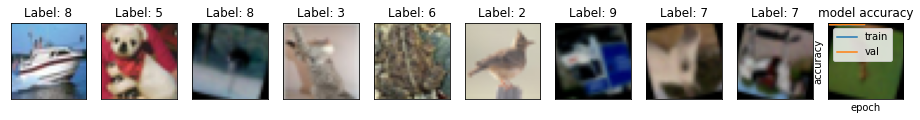

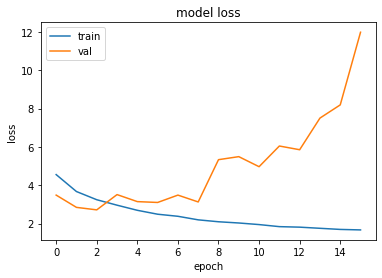

Early Stop Epoch:  5  when Val Acc was:  0.21379999816417694
TestLoss:  3.118468761444092  TestAcc: 0.218299999833107
Run:  2
blur is not 0
pChannelShuffle:  1


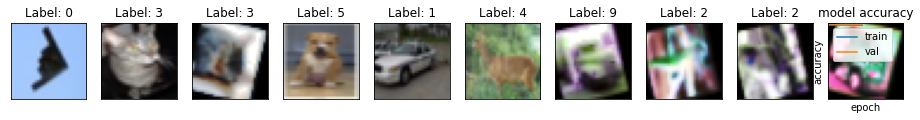

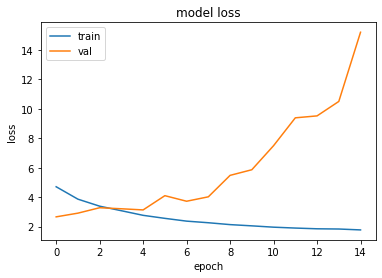

Early Stop Epoch:  4  when Val Acc was:  0.18790000677108765
TestLoss:  3.1441762447357178  TestAcc: 0.1858000010251999
Run:  3
blur is 0
pChannelShuffle:  1


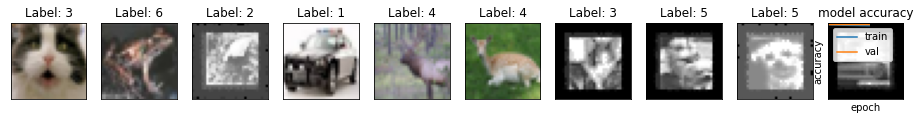

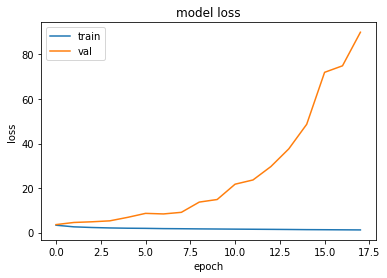

Early Stop Epoch:  7  when Val Acc was:  0.10980000346899033
TestLoss:  9.121990203857422  TestAcc: 0.10909999907016754
Run:  4
blur is not 0
pChannelShuffle:  1


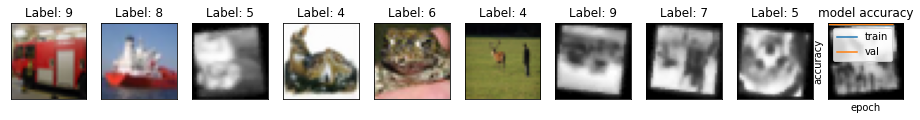

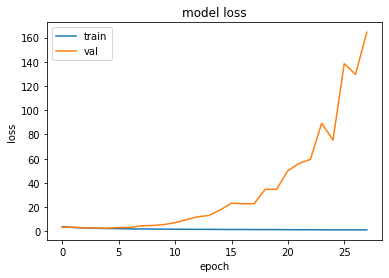

Early Stop Epoch:  17  when Val Acc was:  0.18230000138282776
TestLoss:  22.876588821411133  TestAcc: 0.18279999494552612
Run:  5
blur is not 0
pChannelShuffle:  1


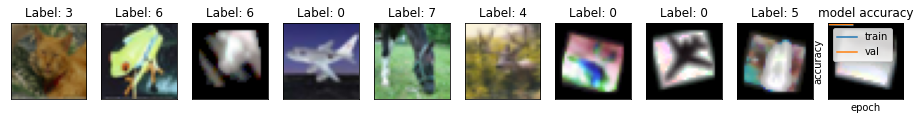

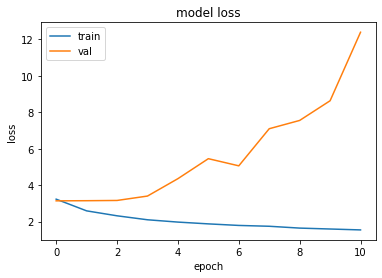

Early Stop Epoch:  0  when Val Acc was:  0.11069999635219574
TestLoss:  3.145789384841919  TestAcc: 0.11140000075101852


Run:  6
blur is not 0
pChannelShuffle:  0


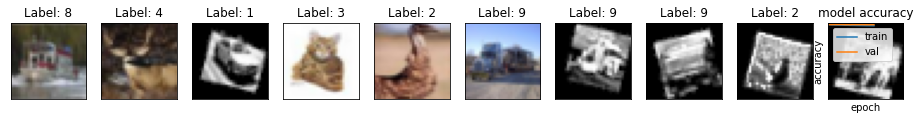

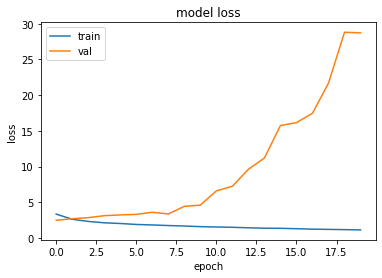

Early Stop Epoch:  9  when Val Acc was:  0.20409999787807465
TestLoss:  4.579843521118164  TestAcc: 0.20499999821186066


Run:  7
blur is 0
pChannelShuffle:  1


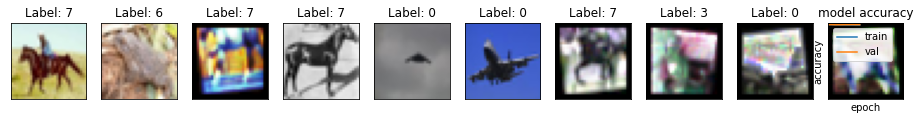

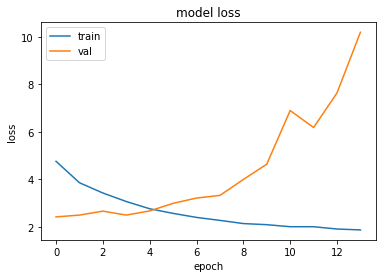

Early Stop Epoch:  3  when Val Acc was:  0.20029999315738678
TestLoss:  2.488969087600708  TestAcc: 0.20409999787807465
Run:  8
blur is not 0
pChannelShuffle:  1


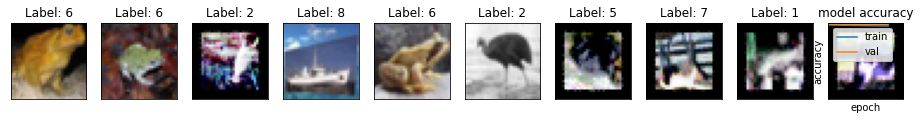

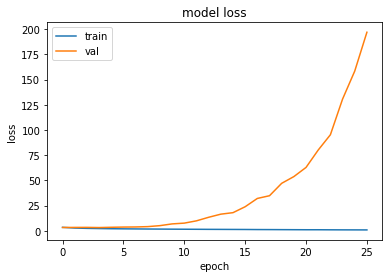

Early Stop Epoch:  15  when Val Acc was:  0.16099999845027924
TestLoss:  23.96808433532715  TestAcc: 0.15479999780654907
Run:  9
blur is not 0
pChannelShuffle:  0


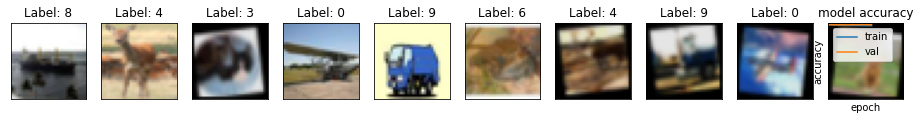

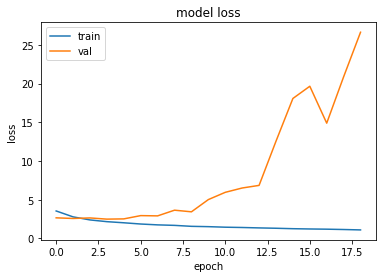

Early Stop Epoch:  8  when Val Acc was:  0.25270000100135803
TestLoss:  3.4517409801483154  TestAcc: 0.24289999902248383
Run:  10
blur is not 0
pChannelShuffle:  1


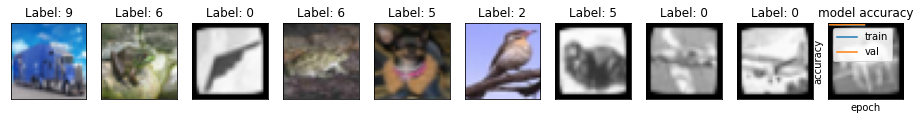

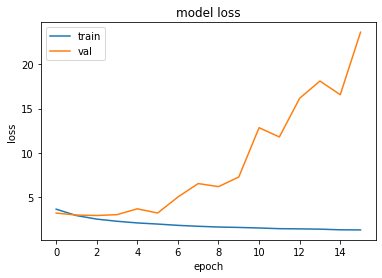

Early Stop Epoch:  5  when Val Acc was:  0.22280000150203705
TestLoss:  3.247466564178467  TestAcc: 0.22599999606609344
Run:  11
blur is not 0
pChannelShuffle:  1


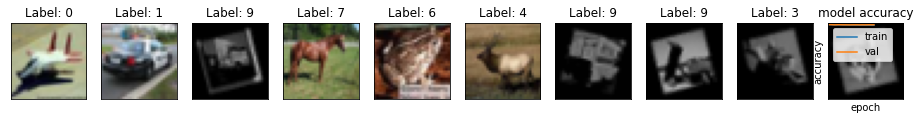

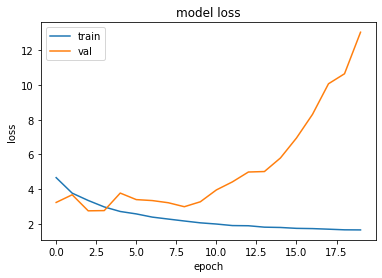

Early Stop Epoch:  9  when Val Acc was:  0.23600000143051147
TestLoss:  3.2824316024780273  TestAcc: 0.2393999993801117
Run:  12
blur is not 0
pChannelShuffle:  0


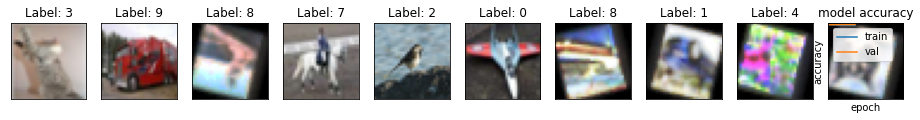

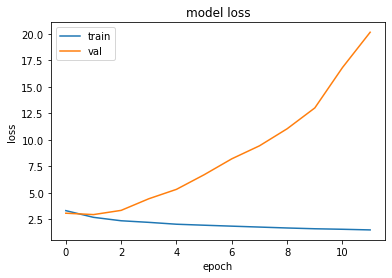

Early Stop Epoch:  1  when Val Acc was:  0.1501999944448471
TestLoss:  2.9508843421936035  TestAcc: 0.14030000567436218
Run:  13
blur is 0
pChannelShuffle:  1


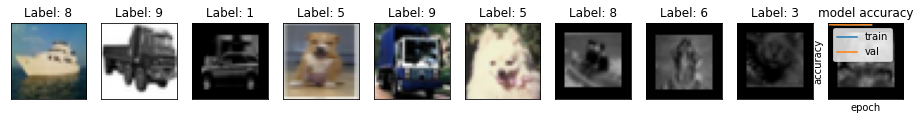

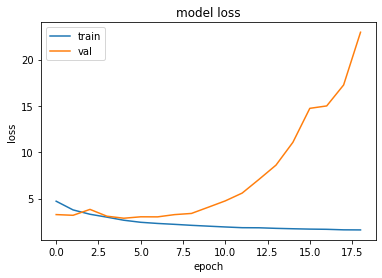

Early Stop Epoch:  8  when Val Acc was:  0.25760000944137573
TestLoss:  3.386690139770508  TestAcc: 0.2540999948978424
Run:  14
blur is 0
pChannelShuffle:  0


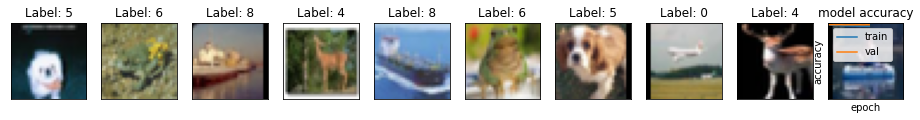

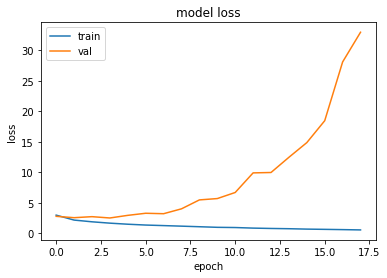

Early Stop Epoch:  7  when Val Acc was:  0.2206999957561493
TestLoss:  4.019227504730225  TestAcc: 0.21930000185966492
Run:  15
blur is not 0
pChannelShuffle:  1


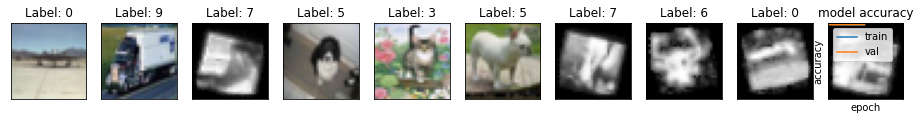

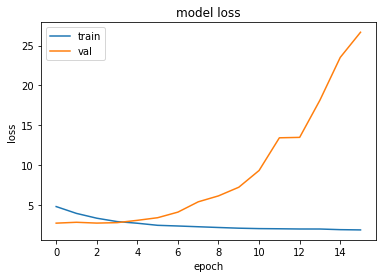

Early Stop Epoch:  5  when Val Acc was:  0.16869999468326569
TestLoss:  3.3928356170654297  TestAcc: 0.1688999980688095
Run:  16
blur is not 0
pChannelShuffle:  0


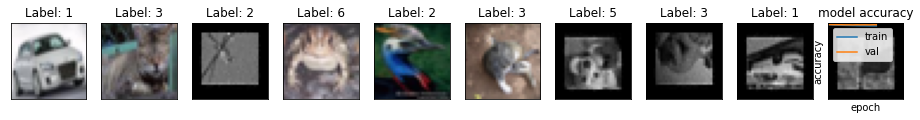

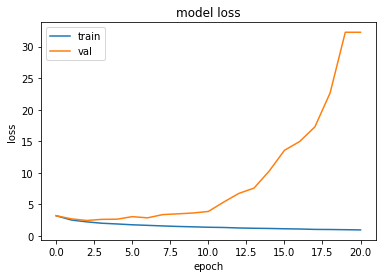

Early Stop Epoch:  10  when Val Acc was:  0.25049999356269836
TestLoss:  3.9242773056030273  TestAcc: 0.24619999527931213
Run:  17
blur is 0
pChannelShuffle:  1


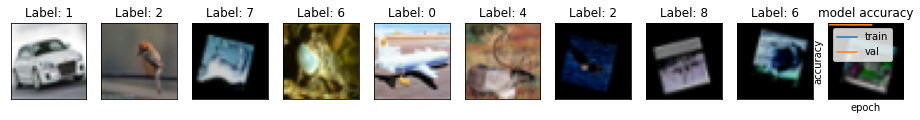

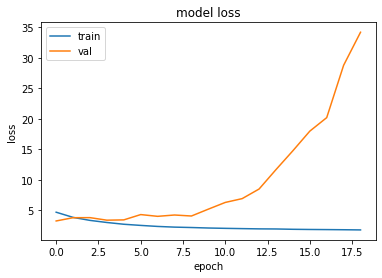

Early Stop Epoch:  8  when Val Acc was:  0.210999995470047
TestLoss:  4.060844421386719  TestAcc: 0.2150000035762787
Run:  18
blur is not 0
pChannelShuffle:  1


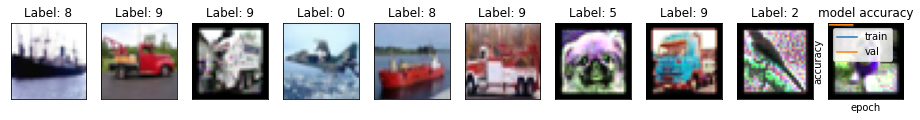

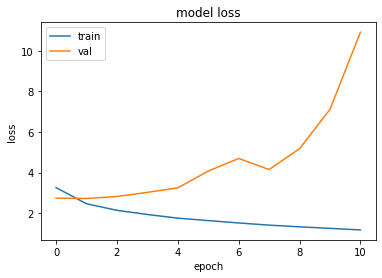

Early Stop Epoch:  0  when Val Acc was:  0.14550000429153442
TestLoss:  2.7400803565979004  TestAcc: 0.1459999978542328
Run:  19
blur is 0
pChannelShuffle:  0


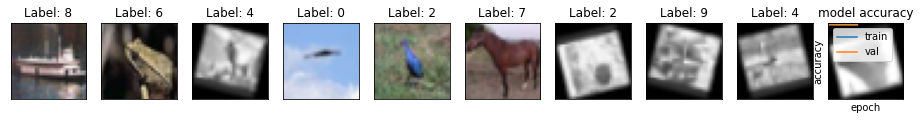

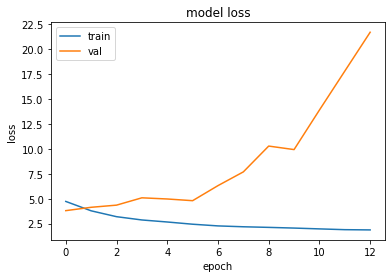

Early Stop Epoch:  2  when Val Acc was:  0.16269999742507935
TestLoss:  4.368380546569824  TestAcc: 0.16609999537467957
Run:  20
blur is 0
pChannelShuffle:  1


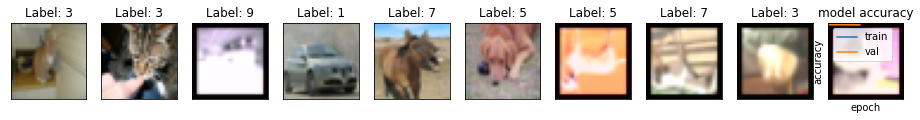

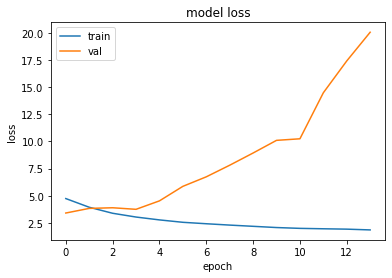

Early Stop Epoch:  3  when Val Acc was:  0.14669999480247498
TestLoss:  3.7496798038482666  TestAcc: 0.14949999749660492
Run:  21
blur is 0
pChannelShuffle:  0


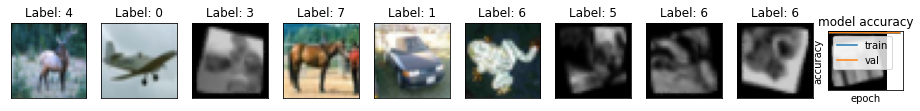

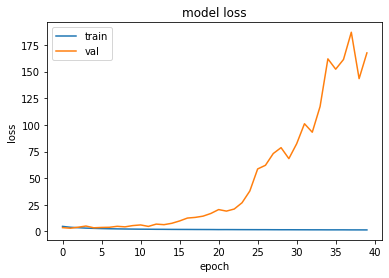

Early Stop Epoch:  29  when Val Acc was:  0.265500009059906
TestLoss:  68.40391540527344  TestAcc: 0.2669999897480011
Run:  22
blur is not 0
pChannelShuffle:  0


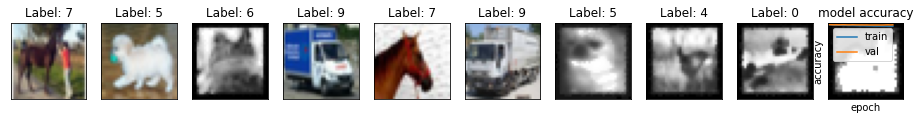

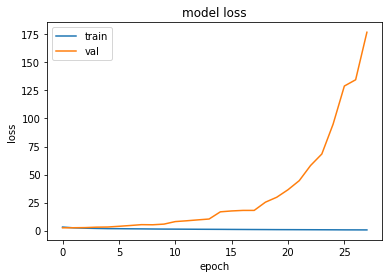

Early Stop Epoch:  17  when Val Acc was:  0.2913999855518341
TestLoss:  18.08335304260254  TestAcc: 0.298799991607666
Run:  23
blur is 0
pChannelShuffle:  0


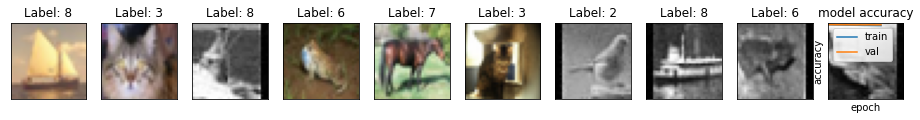

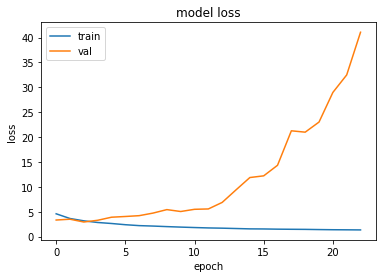

Early Stop Epoch:  12  when Val Acc was:  0.23430000245571136
TestLoss:  6.945060729980469  TestAcc: 0.2304999977350235
Run:  24
blur is not 0
pChannelShuffle:  0


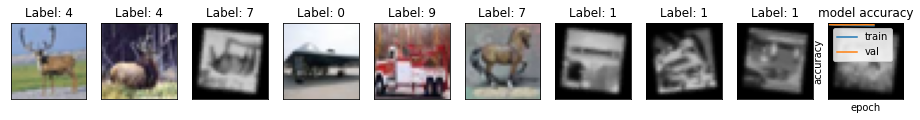

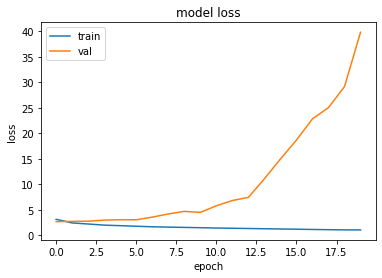

Early Stop Epoch:  9  when Val Acc was:  0.22689999639987946
TestLoss:  4.517534255981445  TestAcc: 0.22859999537467957
Run:  25
blur is 0
pChannelShuffle:  0


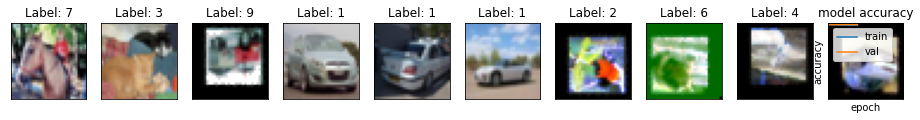

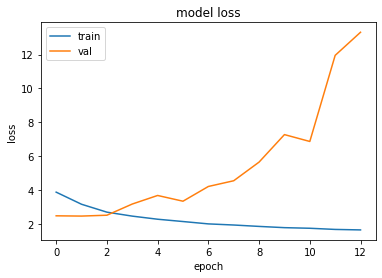

Early Stop Epoch:  2  when Val Acc was:  0.1559000015258789
TestLoss:  2.522054672241211  TestAcc: 0.1559000015258789
Run:  26
blur is 0
pChannelShuffle:  0


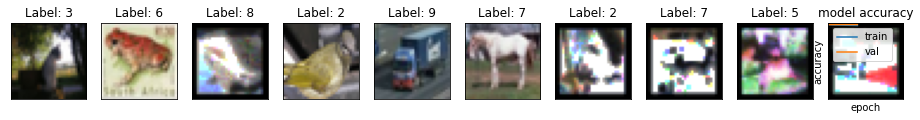

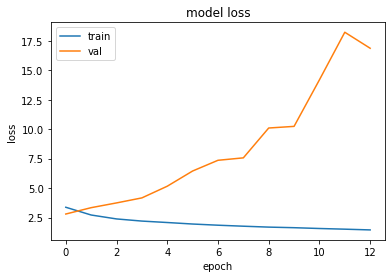

Early Stop Epoch:  2  when Val Acc was:  0.11729999631643295
TestLoss:  3.7496440410614014  TestAcc: 0.11400000005960464
Run:  27
blur is not 0
pChannelShuffle:  0


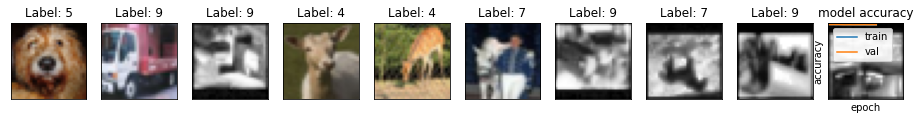

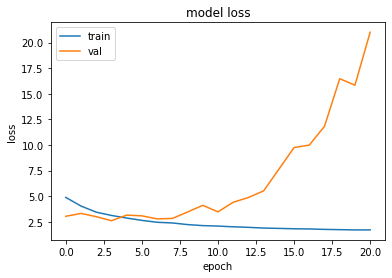

Early Stop Epoch:  10  when Val Acc was:  0.21170000731945038
TestLoss:  3.4549574851989746  TestAcc: 0.21369999647140503
Run:  28
blur is not 0
pChannelShuffle:  1


In [ ]:
import pickle

# The augmented data returns floats between 0 and 1
# The unaugmented data is integers uint8 between 0 and 255 

unbatch_train_A = (tf.data.Dataset.unbatch(train_A))
#No Augmentations "No Albumentations"
train_A_noalb = unbatch_train_A.map(set_shapes, num_parallel_calls=AUTOTUNE)
train_A_noalb = train_A_noalb.map(partial(no_process_data, img_size=IMG_SIZE),
                  num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
 
# print(train_A_noalb)  # types: (tf.uint8, tf.int64)>
# print(train_A_alb)

# def cache_prefetch_group(train_tf):
    
#     train_tf = train_tf.shuffle(5000, reshuffle_each_iteration=True, seed=seed)
#     train_tf = train_tf.cache().prefetch(buffer_size=AUTOTUNE)
#     train_tf = train_tf.batch(1000)  # I believe its good to not have a remainder to cut ds evenly but I'm not sure
#     return train_tf 



CLASSES = info.features['label'].names

def show_confusion_matrix(test_labels, predictions, CLASSES):
    """Compute confusion matrix and normalize."""
    confusion = sklearn.metrics.confusion_matrix(test_labels, predictions,  labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
    
    confusing_part_matrix= np.array(confusion)-np.identity(confusion.shape[0])*np.diag(confusion)
  
    axis_labels = CLASSES
  
    ax = sns.heatmap(
        confusing_part_matrix, xticklabels=axis_labels, yticklabels=axis_labels,
        cmap='Blues', annot=True, square=True, fmt='.0f')

    plt.title("Confusion matrix without Diagonal")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")




Group_A_Runs = {}   #dictionary
# Group_A_Runs[run] = {'TestAccuracy': 0}


for run in range(50): # df_experimentalruns['xRun']:
  run = run + 1  
  print("Run: ", run)

  
  model = makemodel(DROPOUT=df_experimentalruns.loc[run,'dropout' ])
  list_of_transforms = augmentfunction( df_experimentalruns, run )
 
  transforms = A.Compose(transforms = list_of_transforms)
  
  # Augmentations "Albumentations"
  train_A_alb = unbatch_train_A.map(partial(process_data, img_size=IMG_SIZE),
                  num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)

  train_A_alb = train_A_alb.map(set_shapes, num_parallel_calls=AUTOTUNE)

  # train_A_noalb.shuffle(buffer_size=2500, reshuffle_each_iteration=True, seed=seed)
  # train_A_alb.shuffle(buffer_size = 5000, reshuffle_each_iteration=True, seed=seed)

  new_train_A = train_A_alb.concatenate(train_A_noalb)
  # new_train_A = cache_prefetch_group(new_train_A)

  #Is there something I can do to below to speed up training better?
  new_train_A = new_train_A.shuffle(buffer_size=5000, reshuffle_each_iteration=True, seed = seed).cache().prefetch(buffer_size=AUTOTUNE).batch(250)

  view_image(new_train_A)  # the labels looked mostly right that I could tell, 

  # ALLLLLLLLLLLL my time spent here
  modeltrained = trainmodel(MODEL = model, TRAININGDATA= new_train_A)


  # train_A_alb_new = cache_prefetch_group(train_A_alb)
  # view_image(train_A_alb_new)
  # modeltrained = trainmodel(MODEL = model, TRAININGDATA= train_A_alb_new)

  loss, acc = modeltrained.evaluate(x_test, verbose=0) 
  print("TestLoss: ", loss, " TestAcc:", acc)

  y_pred = modeltrained.predict(x_test)
  # I need to convert this large y_pred of continuous probabilities into a 1-coded label vectors
  y_pred_1hot = np.argmax(y_pred, axis=1)
  cm = confusion_matrix(y_true = y_test, y_pred = y_pred_1hot,  labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9] ) 
  # disp = ConfusionMatrixDisplay(cm, display_labels=['airplane', 'automobile','bird','cat','deer','dog','frog','horse','ship','truck']).plot()
  # print(cm)

  # confusion_matrix(y_true = y_test, y_pred = y_pred_1hot )
  # show_confusion_matrix(y_test, y_pred_1hot, CLASSES = CLASSES)

  Group_A_Runs[run] = {'TestAccuracy': acc, 'TestLoss': loss, 'CM': cm}

now = time.time()
print(now - start_augmentations , "secs for training augmented data through model")

### Confusion Matrix on Test-Set Data 

In [ ]:
for k, v in Group_A_Runs.items():
   a_line = print(k, v)

with open('pickled_data_file.pkl', 'wb') as fid:
     pickle.dump(Group_A_Runs, fid)



from google.colab import files
files.download('pickled_data_file.pkl')

# for k, v in Group_A_Runs.items():
#   with open('group_a_runs.txt', 'w') as writefile:
#     a_line = k +  v
#     writefile.write(a_line)

In [ ]:
import pickle
with open('pickled_data_file.pkl', 'rb') as fid:
     data3 = pickle.load(fid)  #this file originally saved 10-31-2021 in my downlods


data3[1]